# 构建数据集

构建自己的数据集

In [2]:
import torch
from torch import nn

torch.__version__

'1.10.0'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 获取自己的数据

机器学习是一个迭代的过程，因此可以从小的数据集开始，如果小的数据集可以跑的通的话，那就可以在必要的时候扩充数据集。


In [4]:
# 下载数据
import requests
import zipfile
from pathlib import Path

# Setup path to data folder ，创建图片保存的地址
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():  # 判断图片地址是否存在
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)  # 如果路径不存在，那就创建文件夹
    
    # 代理服务器设置
    proxies = {
        "http": "http://127.0.0.1:7890",  # 替换为你的代理服务器配置
        "https": "http://127.0.0.1:7890"
    }
    
    # Download pizza, steak, sushi data
    try:
        with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
            print("Downloading pizza, steak, sushi data...")
            request = requests.get(
                "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                verify=False,  # 忽略 SSL 证书验证
                proxies=proxies  # 使用代理下载
            )
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
            print("Unzipping pizza, steak, sushi data...") 
            zip_ref.extractall(image_path)

    except requests.exceptions.RequestException as e:
        print(f"An error occurred during the download: {e}")


data\pizza_steak_sushi directory exists.


### 查看文件结构

In [5]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [7]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir,test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 查看数据
1. 使用 pathlib.Path.glob() 找到所有以 .jpg 结尾的文件，获取所有图片路径。
2. 使用 Python 的 random.choice() 随机选择一个图片路径。
3. 使用 pathlib.Path.parent.stem 获取图片的类别名称。
4. 由于我们在处理图片，所以我们将使用 PIL.Image.open() 来打开随机选择的图片路径（PIL 代表 Python 图像库）。
5. 然后，我们会展示这张图片，并打印一些元数据。


Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


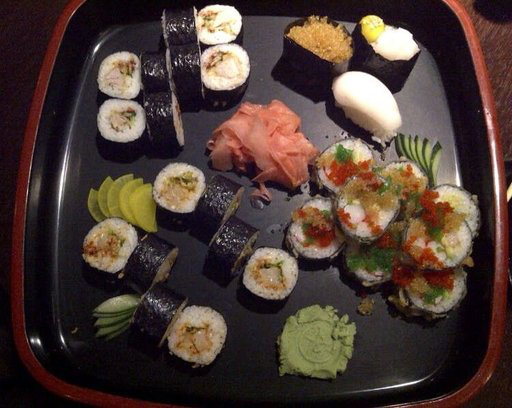

In [8]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

## 数据转换

对自己的数据处理按照以下的步骤来：
1. 将数据转为tensor，这样的话模型可以处理，使用transforms函数
   * torchvision.transforms 有很对在构建模型之前的方法去操控数据，可以将它们转变为tensor，同时可以改变他们的形状，以及进行数据增强。
2. 将数据变为一个dataset，然后使用dataloader去加载数据。
   
多模态数据的dataset：
| Problem space          | Pre-built Datasets and Functions  |
|------------------------|-----------------------------------|
| Vision                 | `torchvision.datasets`            |
| Audio                  | `torchaudio.datasets`             |
| Text                   | `torchtext.datasets`              |
| Recommendation system  | `torchrec.datasets`               |


In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

In [10]:
data_transform = transforms.Compose([
    # 改变图片大小，变为64x64
    transforms.Resize(size=(64, 64)),
    # 数据增强，随机在水平方向翻转
    transforms.RandomHorizontalFlip(p=0.5),
    # 将图片变为tensor类型
    transforms.ToTensor()
])

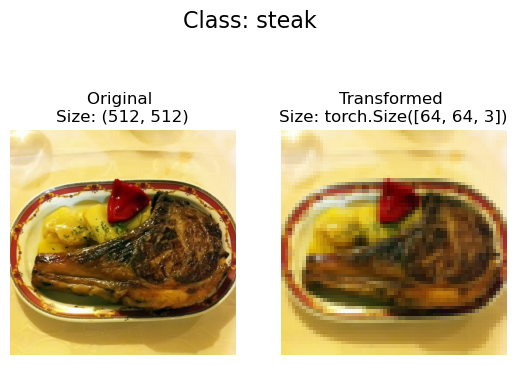

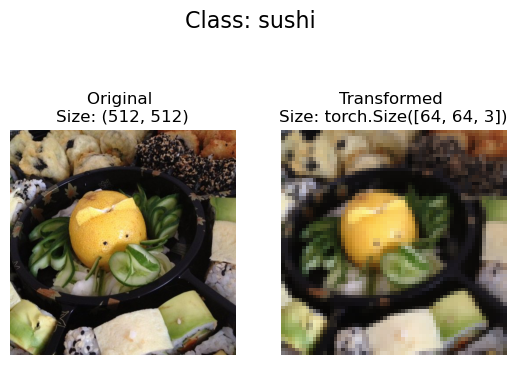

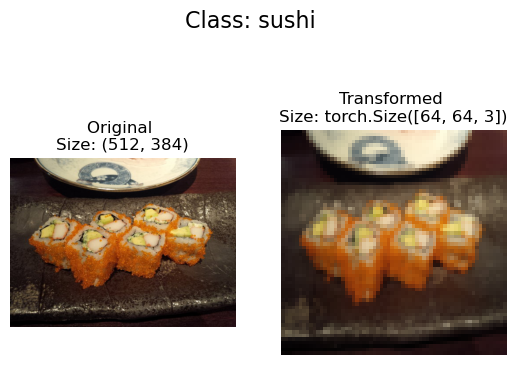

In [11]:
import matplotlib.pyplot as plt
def plot_transformed_imgs(image_paths,transform, n = 3, seed = 44):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths,k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_imgs(image_path_list, 
                      transform=data_transform, 
                      n=3)

## load data
### ImageFolder

当图片所在的文件夹的结构如下所示时，可以使用torchvision.datasets.ImageFolder进行数据导入。
```bash
root/          # 数据集根目录
    class1/    # 类别1的文件夹
        img1.jpg
        img2.jpg
        ...
    class2/    # 类别2的文件夹
        img1.jpg
        img2.jpg
        ...

```

In [12]:
from torchvision import datasets

train_data = datasets.ImageFolder(
    root=train_dir, # 确定该数据集存储的地点
    transform=data_transform, # 是否要对数据进行变换
    target_transform= None # 是否要对标签进行变换
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform = data_transform,

)
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [13]:
'''
classes 属性存储了按字母顺序排列的类名列表。
也就是说，train_data.classes 会返回图像数据集中类别的名称列表。
根据类别子文件夹的名称确定类别数。
'''
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
img,label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


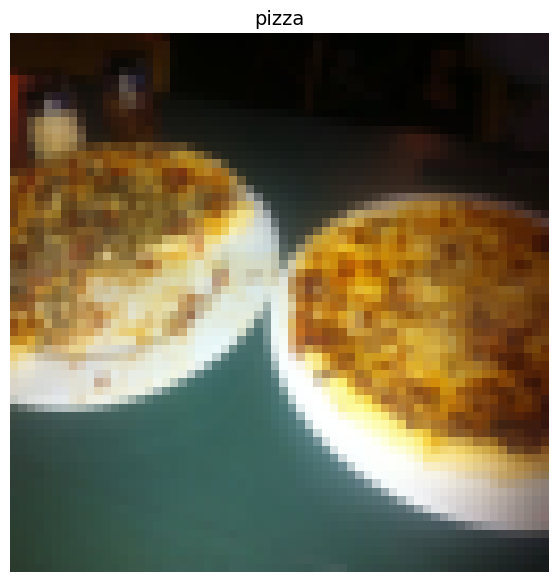

In [16]:
# 注意，使用torch读取的图片是CHW,matplotlib需要的格式是HWC

img_permute = img.permute(1,2,0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [17]:
# 将数据转为模型可以处理的

batch_size = 32

from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              num_workers=8,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             num_workers=8,
                             shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2424e4a6790>,
 <torch.utils.data.dataloader.DataLoader at 0x2424e4a67f0>)

In [18]:
# 首先，我们需要使用 DataLoader 来加载数据。通常 DataLoader 是可迭代的，
# 但这里我们手动使用 iter() 函数将其转换为迭代器，以便可以使用 next() 来控制每次迭代。
# next() 会返回一个 tuple，其中包含 (images, labels)，这两个是批次的张量。
img, label = next(iter(train_dataloader))
# Batch size will now be 32, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## ★构建自己的dataset代码

In [19]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [20]:
def find_classes(directory:str) -> Tuple[List]:
    """在目标目录中查找类别文件夹名称。

    假设目标目录采用标准的图像分类格式。

    参数：
        directory (str): 要加载类别名称的目标目录。

    返回值：
        Tuple[List[str], Dict[str, int]]: (类别名称列表, 字典(类别名称: 索引...))

    示例：
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """

    # 1. 扫描目标文件夹，获取类别名称,也就是所有子文件夹的名字
    # 同时后面的判断就是将文件夹中的非文件夹部分排除，这里就是图片

    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2.抛出异常，如果没有找到类别名称的话
    if not classes:
        raise FileNotFoundError(f'{directory}没有找到任何类别')
    
    # 3. 为索引标签创建字典，符合计算机计算的要求
    class_to_idx = {cls_name: i for i,cls_name in enumerate(classes)}
    return classes, class_to_idx

find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [21]:
# 构建自己的Dataset,需要继承属性
from torch.utils.data import Dataset

# 创建自己的数据集类
class MyDataset(Dataset):

    # 初始化参数
    def __init__(self,target_dir:str, transform:None) -> None:
        super().__init__()
        # 超参数初始化
        # 获取该路径下的所有的图片地址
        self.paths = list(pathlib.Path(target_dir).glob('*/*.jpg'))
        # 设置图片的变化
        self.transform = transform
        # 为图片数据创建类别以及索引
        self.classes, self.class_to_idx = find_classes(target_dir)

    # 创建加载图片的函数
    def load_images(self,idx:int) -> Image.Image:
        # 根据index获取图片的地址，然后打开图片
        img_idx = self.paths[idx]
        return Image.open(img_idx)

    # 重写 __len__() 方法
    def __len__(self) -> int:
        return len(self.paths)
    
    # 重写__getitem__()方法
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        # 返回数据的一个样例，以元组的形式返回
        img = self.load_images(index)
        class_name = self.paths[index].parent.name # 只要是一个合法的文件地址就可以这样做
        class_index = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img),class_index
        else:
            return img,class_index

In [22]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_data_custom = MyDataset(target_dir=train_dir, 
                              transform=train_transforms)
test_data_custom = MyDataset(target_dir=test_dir, 
                             transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.MyDataset at 0x2424e4b6c40>, <__main__.MyDataset at 0x2424e4b6400>)

In [23]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [24]:
train_data_custom.classes,train_data_custom.class_to_idx


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

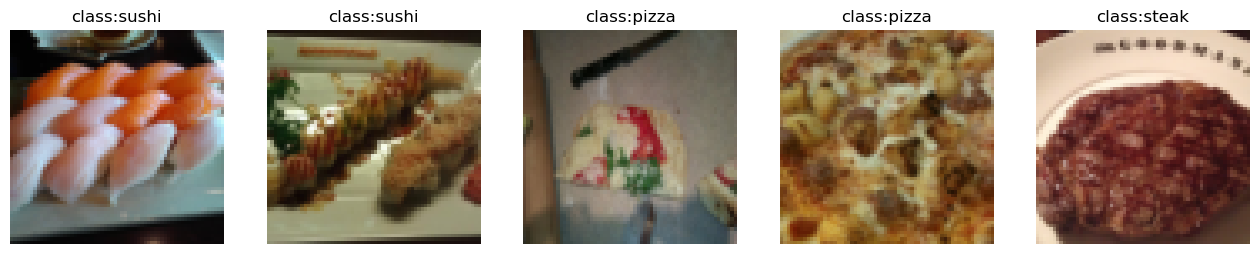

In [25]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # Get Random index
    indexs = random.sample(range(len(dataset)), k=n)

    # set plot figsize 
    plt.figure(figsize=(16,8))

    for i,idx in enumerate(indexs):
        targ_img,targ_label = dataset[idx][0],dataset[idx][1]

        targ_img_adjust = targ_img.permute(1,2,0)

        # 绘制图片
        plt.subplot(1,n,i+1)
        plt.imshow(targ_img_adjust)
        plt.axis('off')
        if classes:
            title = f'class:{classes[targ_label]}'
            if display_shape:
                title = title + f'\n shape:{targ_img_adjust.shape}'

        plt.title(title)

display_random_images(
    train_data_custom,
    n = 5,
    display_shape=False,
    seed=None,
    classes=class_names
)

In [26]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x2424e6635e0>,
 <torch.utils.data.dataloader.DataLoader at 0x2424e6632e0>)

In [27]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 图像数据增强

实际上已经有研究表明使用随即增强方法transforms.RandomAugment()和transforms.TrivialAugmentWide()比手动选择转换方式更好。

In [28]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # 确定增强的强度 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

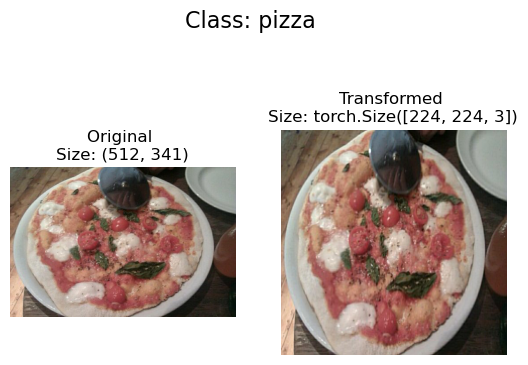

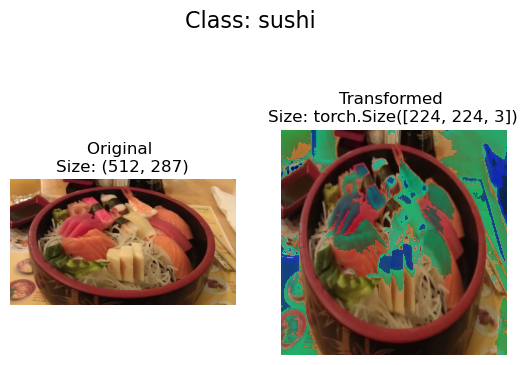

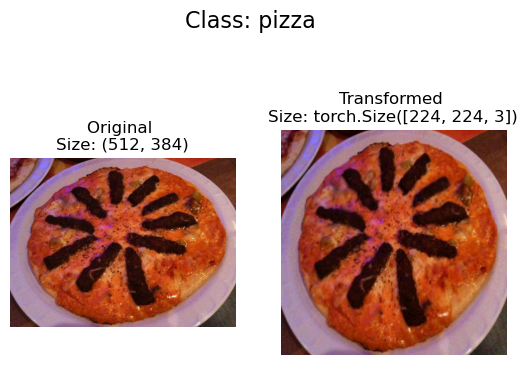

In [29]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_imgs(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

## 构建模型以训练

In [54]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

torch.manual_seed(42)
# Create train and test datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

# Create train and test dataloaders
train_dataloader_augmented = DataLoader(dataset=train_data_augmented, batch_size=8, shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple, batch_size=8, shuffle=False)

train_dataloader_augmented,test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x2424e498520>,
 <torch.utils.data.dataloader.DataLoader at 0x242f7658a30>)

## 2d卷积的原理

在 2D 卷积中，输入特征的通道数（`inputC`）和输出特征的通道数（`outC`）定义了卷积操作的基本结构。

- **输入特征**：
  - 假设输入图像的形状为 $$H \times W \times 3$$，其中 \(H\) 是高度，\(W\) 是宽度，`3` 表示 RGB 图像的通道数。

- **卷积核**：
  - 当 `inputC = 3` 和 `outC = 64` 时，会有 64 个卷积核（滤波器），每个卷积核的形状为 $$K \times K \times 3$$，其中 \(K\) 是卷积核的空间尺寸（通常为 3、5 或 7）。

- **卷积操作**：
  1. 每个卷积核会在输入图像上滑动，进行如下步骤：
     - 将卷积核的权重（大小为 $$K \times K \times 3$$）与对应的输入图像区域的像素值相乘。
     - 将所有乘积相加，并加上偏置项（如果有）。
     - 将结果作为输出特征图中的一个单元。

- **输出特征图**：
  - 因为有 64 个卷积核，所以会生成 64 个输出特征图（激活图），每个特征图的深度为 1。
  - 如果卷积操作不改变输入图像的空间维度（通过适当的填充和步幅设置），则每个输出特征图的形状为 $$H' \times W'$$，输出的特征图总的形状为 $$H' \times W' \times 64$$。


假设我们有一个输入图像的形状为 $$224 \times 224 \times 3$$，使用 $$3 \times 3$$ 的卷积核，输出通道数为 64：

- 每个卷积核的形状为 $$3 \times 3 \times 3$$。
- 进行卷积操作后，得到的输出特征图的形状为 $$224 \times 224$$



In [36]:
class VGG16(nn.Module):
    def __init__(self, output_shape: int) -> None:
        super(VGG16,self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=512 * 7 * 7, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=output_shape),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return x


In [37]:
summary(vgg, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG16                                    [1, 3]                    --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In [46]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    train_loss, train_acc = 0,0

    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1))
        train_acc += (y_pred_class==y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [47]:
from tqdm import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10):
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
                # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results


In [56]:
import torchvision.models as models

# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 加载预训练的 VGG16 模型
vgg = VGG16(output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
op = torch.optim.Adam(params=vgg.parameters(),lr=1e-3)

vgg_results = train(
    model=vgg,
    train_dataloader=train_dataloader_augmented,
    test_dataloader=test_dataloader_simple,
    optimizer=op,
    loss_fn=loss_fn,
    epochs=100
)

  1%|          | 1/100 [01:22<2:16:20, 82.63s/it]

Epoch: 1 | train_loss: 1.1109 | train_acc: 0.0388 | test_loss: 1.1261 | test_acc: 0.3125


  2%|▏         | 2/100 [02:45<2:14:45, 82.50s/it]

Epoch: 2 | train_loss: 1.1051 | train_acc: 0.0216 | test_loss: 1.1050 | test_acc: 0.3125


  3%|▎         | 3/100 [04:07<2:13:19, 82.47s/it]

Epoch: 3 | train_loss: 1.1021 | train_acc: 0.0474 | test_loss: 1.1106 | test_acc: 0.3125


  4%|▍         | 4/100 [05:29<2:11:55, 82.45s/it]

Epoch: 4 | train_loss: 1.0982 | train_acc: 0.0345 | test_loss: 1.1030 | test_acc: 0.3125


  5%|▌         | 5/100 [06:52<2:10:33, 82.46s/it]

Epoch: 5 | train_loss: 1.0999 | train_acc: 0.0302 | test_loss: 1.1035 | test_acc: 0.3125


  6%|▌         | 6/100 [08:14<2:09:15, 82.51s/it]

Epoch: 6 | train_loss: 1.0998 | train_acc: 0.0647 | test_loss: 1.1091 | test_acc: 0.3125


  7%|▋         | 7/100 [09:38<2:08:13, 82.72s/it]

Epoch: 7 | train_loss: 1.1013 | train_acc: 0.0086 | test_loss: 1.1077 | test_acc: 0.3125


  8%|▊         | 8/100 [11:01<2:07:08, 82.92s/it]

Epoch: 8 | train_loss: 1.1033 | train_acc: 0.0302 | test_loss: 1.1153 | test_acc: 0.3125


  9%|▉         | 9/100 [12:24<2:05:57, 83.05s/it]

Epoch: 9 | train_loss: 1.0972 | train_acc: 0.0819 | test_loss: 1.1009 | test_acc: 0.3125


 10%|█         | 10/100 [13:48<2:04:41, 83.13s/it]

Epoch: 10 | train_loss: 1.1028 | train_acc: 0.0129 | test_loss: 1.1049 | test_acc: 0.3125


 11%|█         | 11/100 [15:11<2:03:24, 83.19s/it]

Epoch: 11 | train_loss: 1.0981 | train_acc: 0.0259 | test_loss: 1.1088 | test_acc: 0.3125


 12%|█▏        | 12/100 [16:34<2:02:05, 83.24s/it]

Epoch: 12 | train_loss: 1.1034 | train_acc: 0.0819 | test_loss: 1.1083 | test_acc: 0.3125


 13%|█▎        | 13/100 [17:58<2:00:43, 83.26s/it]

Epoch: 13 | train_loss: 1.0996 | train_acc: 0.0517 | test_loss: 1.1010 | test_acc: 0.2375


 14%|█▍        | 14/100 [19:21<1:59:22, 83.28s/it]

Epoch: 14 | train_loss: 1.1012 | train_acc: 0.0431 | test_loss: 1.0961 | test_acc: 0.4500


 15%|█▌        | 15/100 [20:44<1:58:02, 83.32s/it]

Epoch: 15 | train_loss: 1.1016 | train_acc: 0.0216 | test_loss: 1.1069 | test_acc: 0.2375


 16%|█▌        | 16/100 [22:08<1:56:39, 83.32s/it]

Epoch: 16 | train_loss: 1.1068 | train_acc: 0.0388 | test_loss: 1.1119 | test_acc: 0.2375


 17%|█▋        | 17/100 [23:31<1:55:16, 83.33s/it]

Epoch: 17 | train_loss: 1.1007 | train_acc: 0.0216 | test_loss: 1.0973 | test_acc: 0.4500


 18%|█▊        | 18/100 [24:54<1:53:55, 83.36s/it]

Epoch: 18 | train_loss: 1.1018 | train_acc: 0.0302 | test_loss: 1.1036 | test_acc: 0.3125


 19%|█▉        | 19/100 [26:18<1:52:30, 83.34s/it]

Epoch: 19 | train_loss: 1.0995 | train_acc: 0.0862 | test_loss: 1.1060 | test_acc: 0.3125


 20%|██        | 20/100 [27:41<1:51:05, 83.32s/it]

Epoch: 20 | train_loss: 1.0992 | train_acc: 0.0560 | test_loss: 1.0995 | test_acc: 0.3125


 21%|██        | 21/100 [29:04<1:49:42, 83.32s/it]

Epoch: 21 | train_loss: 1.1012 | train_acc: 0.0733 | test_loss: 1.0957 | test_acc: 0.3125


 22%|██▏       | 22/100 [30:28<1:48:18, 83.32s/it]

Epoch: 22 | train_loss: 1.0998 | train_acc: 0.0991 | test_loss: 1.0963 | test_acc: 0.3125


 23%|██▎       | 23/100 [31:51<1:46:54, 83.30s/it]

Epoch: 23 | train_loss: 1.1003 | train_acc: 0.0431 | test_loss: 1.0942 | test_acc: 0.4500


 24%|██▍       | 24/100 [33:14<1:45:30, 83.29s/it]

Epoch: 24 | train_loss: 1.0972 | train_acc: 0.0345 | test_loss: 1.0970 | test_acc: 0.3125


 25%|██▌       | 25/100 [34:37<1:44:06, 83.28s/it]

Epoch: 25 | train_loss: 1.0975 | train_acc: 0.0905 | test_loss: 1.1005 | test_acc: 0.3125


 26%|██▌       | 26/100 [36:01<1:42:55, 83.45s/it]

Epoch: 26 | train_loss: 1.1004 | train_acc: 0.0302 | test_loss: 1.1008 | test_acc: 0.3125


 27%|██▋       | 27/100 [37:25<1:41:38, 83.55s/it]

Epoch: 27 | train_loss: 1.1002 | train_acc: 0.0043 | test_loss: 1.0992 | test_acc: 0.3125


 28%|██▊       | 28/100 [38:49<1:40:20, 83.62s/it]

Epoch: 28 | train_loss: 1.1002 | train_acc: 0.0474 | test_loss: 1.1058 | test_acc: 0.2375


 29%|██▉       | 29/100 [40:13<1:38:59, 83.66s/it]

Epoch: 29 | train_loss: 1.1013 | train_acc: 0.0302 | test_loss: 1.1057 | test_acc: 0.3125


 30%|███       | 30/100 [41:36<1:37:39, 83.71s/it]

Epoch: 30 | train_loss: 1.0985 | train_acc: 0.0862 | test_loss: 1.1011 | test_acc: 0.3125


 31%|███       | 31/100 [43:00<1:36:18, 83.75s/it]

Epoch: 31 | train_loss: 1.1022 | train_acc: 0.0388 | test_loss: 1.0974 | test_acc: 0.3125


 32%|███▏      | 32/100 [44:24<1:34:55, 83.76s/it]

Epoch: 32 | train_loss: 1.1011 | train_acc: 0.0259 | test_loss: 1.1019 | test_acc: 0.3125


 33%|███▎      | 33/100 [45:48<1:33:31, 83.76s/it]

Epoch: 33 | train_loss: 1.0982 | train_acc: 0.0345 | test_loss: 1.1037 | test_acc: 0.3125


 34%|███▍      | 34/100 [47:12<1:32:09, 83.78s/it]

Epoch: 34 | train_loss: 1.1001 | train_acc: 0.0862 | test_loss: 1.1055 | test_acc: 0.3125


 35%|███▌      | 35/100 [48:35<1:30:45, 83.78s/it]

Epoch: 35 | train_loss: 1.1029 | train_acc: 0.0302 | test_loss: 1.1022 | test_acc: 0.3125


 36%|███▌      | 36/100 [49:59<1:29:22, 83.79s/it]

Epoch: 36 | train_loss: 1.1033 | train_acc: 0.0302 | test_loss: 1.1087 | test_acc: 0.3125


 37%|███▋      | 37/100 [51:23<1:27:59, 83.81s/it]

Epoch: 37 | train_loss: 1.0985 | train_acc: 0.1121 | test_loss: 1.1044 | test_acc: 0.3125


 38%|███▊      | 38/100 [52:47<1:26:36, 83.81s/it]

Epoch: 38 | train_loss: 1.1002 | train_acc: 0.0647 | test_loss: 1.1029 | test_acc: 0.3125


 39%|███▉      | 39/100 [54:11<1:25:13, 83.82s/it]

Epoch: 39 | train_loss: 1.0989 | train_acc: 0.1034 | test_loss: 1.1005 | test_acc: 0.3125


 40%|████      | 40/100 [55:35<1:23:49, 83.83s/it]

Epoch: 40 | train_loss: 1.0960 | train_acc: 0.0388 | test_loss: 1.1047 | test_acc: 0.3125


 41%|████      | 41/100 [56:58<1:22:24, 83.80s/it]

Epoch: 41 | train_loss: 1.0986 | train_acc: 0.0819 | test_loss: 1.1082 | test_acc: 0.3125


 42%|████▏     | 42/100 [58:22<1:21:02, 83.84s/it]

Epoch: 42 | train_loss: 1.1023 | train_acc: 0.0172 | test_loss: 1.1076 | test_acc: 0.3125


 43%|████▎     | 43/100 [59:46<1:19:39, 83.84s/it]

Epoch: 43 | train_loss: 1.0992 | train_acc: 0.0474 | test_loss: 1.1046 | test_acc: 0.3125


 44%|████▍     | 44/100 [1:01:10<1:18:13, 83.82s/it]

Epoch: 44 | train_loss: 1.1014 | train_acc: 0.0733 | test_loss: 1.0998 | test_acc: 0.3125


 45%|████▌     | 45/100 [1:02:34<1:16:50, 83.83s/it]

Epoch: 45 | train_loss: 1.0984 | train_acc: 0.0172 | test_loss: 1.0997 | test_acc: 0.3125


 46%|████▌     | 46/100 [1:03:58<1:15:27, 83.84s/it]

Epoch: 46 | train_loss: 1.0997 | train_acc: 0.0948 | test_loss: 1.0987 | test_acc: 0.3125


 47%|████▋     | 47/100 [1:05:21<1:14:03, 83.83s/it]

Epoch: 47 | train_loss: 1.0969 | train_acc: 0.0517 | test_loss: 1.1043 | test_acc: 0.3125


 48%|████▊     | 48/100 [1:06:45<1:12:38, 83.82s/it]

Epoch: 48 | train_loss: 1.0961 | train_acc: 0.1121 | test_loss: 1.1045 | test_acc: 0.3125


 49%|████▉     | 49/100 [1:08:09<1:11:15, 83.83s/it]

Epoch: 49 | train_loss: 1.0956 | train_acc: 0.0776 | test_loss: 1.1053 | test_acc: 0.3125


 50%|█████     | 50/100 [1:09:33<1:09:51, 83.83s/it]

Epoch: 50 | train_loss: 1.1014 | train_acc: 0.0388 | test_loss: 1.1049 | test_acc: 0.3125


 51%|█████     | 51/100 [1:10:57<1:08:28, 83.85s/it]

Epoch: 51 | train_loss: 1.1010 | train_acc: 0.0302 | test_loss: 1.1021 | test_acc: 0.3125


 52%|█████▏    | 52/100 [1:12:21<1:07:06, 83.88s/it]

Epoch: 52 | train_loss: 1.1026 | train_acc: 0.0086 | test_loss: 1.0996 | test_acc: 0.3125


 53%|█████▎    | 53/100 [1:13:45<1:05:41, 83.86s/it]

Epoch: 53 | train_loss: 1.0970 | train_acc: 0.0603 | test_loss: 1.0977 | test_acc: 0.3125


 54%|█████▍    | 54/100 [1:15:08<1:04:17, 83.86s/it]

Epoch: 54 | train_loss: 1.0990 | train_acc: 0.0043 | test_loss: 1.1016 | test_acc: 0.3125


 55%|█████▌    | 55/100 [1:16:32<1:02:53, 83.85s/it]

Epoch: 55 | train_loss: 1.0980 | train_acc: 0.0560 | test_loss: 1.0990 | test_acc: 0.3125


 56%|█████▌    | 56/100 [1:17:56<1:01:29, 83.85s/it]

Epoch: 56 | train_loss: 1.0988 | train_acc: 0.0474 | test_loss: 1.0985 | test_acc: 0.3125


 57%|█████▋    | 57/100 [1:19:20<1:00:04, 83.83s/it]

Epoch: 57 | train_loss: 1.1025 | train_acc: 0.0431 | test_loss: 1.0988 | test_acc: 0.3125


 58%|█████▊    | 58/100 [1:20:44<58:40, 83.83s/it]  

Epoch: 58 | train_loss: 1.1025 | train_acc: 0.0345 | test_loss: 1.0983 | test_acc: 0.3125


 59%|█████▉    | 59/100 [1:22:08<57:17, 83.84s/it]

Epoch: 59 | train_loss: 1.0976 | train_acc: 0.0905 | test_loss: 1.1034 | test_acc: 0.3125


 60%|██████    | 60/100 [1:23:31<55:53, 83.85s/it]

Epoch: 60 | train_loss: 1.0979 | train_acc: 0.1164 | test_loss: 1.1027 | test_acc: 0.3125


 61%|██████    | 61/100 [1:24:55<54:30, 83.86s/it]

Epoch: 61 | train_loss: 1.0947 | train_acc: 0.0517 | test_loss: 1.1062 | test_acc: 0.3125


 62%|██████▏   | 62/100 [1:26:19<53:06, 83.85s/it]

Epoch: 62 | train_loss: 1.0996 | train_acc: 0.0690 | test_loss: 1.1078 | test_acc: 0.3125


 63%|██████▎   | 63/100 [1:27:43<51:41, 83.81s/it]

Epoch: 63 | train_loss: 1.0997 | train_acc: 0.0431 | test_loss: 1.1106 | test_acc: 0.2375


 64%|██████▍   | 64/100 [1:29:07<50:17, 83.82s/it]

Epoch: 64 | train_loss: 1.1014 | train_acc: 0.0000 | test_loss: 1.1102 | test_acc: 0.2375


 65%|██████▌   | 65/100 [1:30:31<48:54, 83.84s/it]

Epoch: 65 | train_loss: 1.0992 | train_acc: 0.0647 | test_loss: 1.1071 | test_acc: 0.2375


 65%|██████▌   | 65/100 [1:31:39<49:21, 84.61s/it]


KeyboardInterrupt: 

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();